/var/folders/lp/y6hmrybn04x3xw651zxsy64m0000gn/T/ipykernel_23014/3782043206.py:61: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1805.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


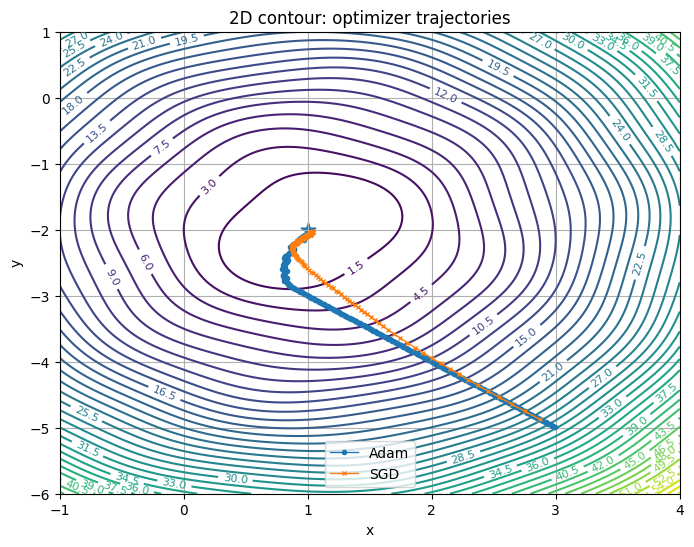

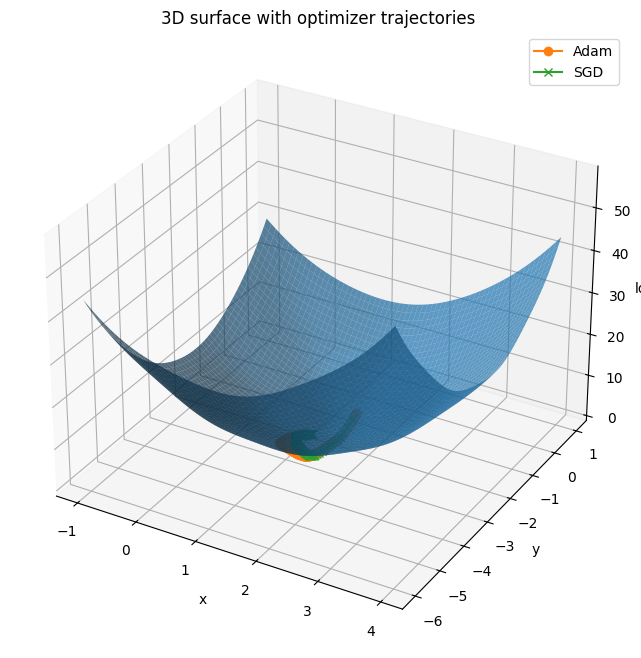

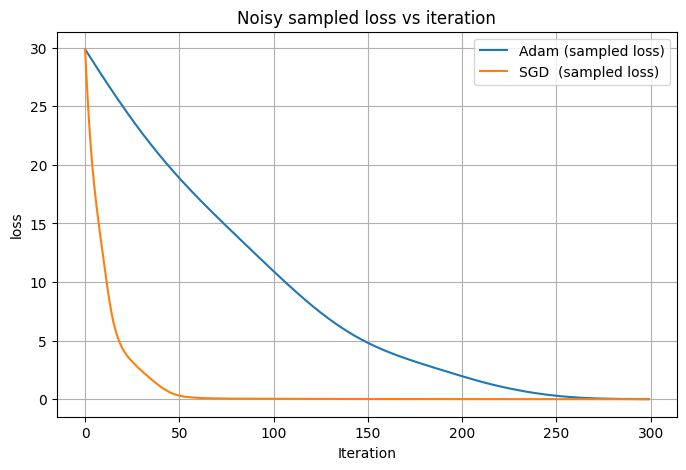

In [1]:
"""
adam_demo_pytorch.py

PyTorch implementation of Adam (Kingma & Ba, 2015) plus 2D & 3D visualizations.
Make sure you have torch and matplotlib installed:
    pip install torch matplotlib

Run:
    python adam_demo_pytorch.py
"""

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import torch
from torch.optim.optimizer import Optimizer

# Path to paper (if you want to open it locally)
# pdf_path = "/mnt/data/1412.6980v9.pdf"
# print("Paper file exists:", os.path.exists(pdf_path), pdf_path)

# -------------------------
# Custom Adam optimizer
# -------------------------
class AdamCustom(Optimizer):
    r"""Adam optimizer implementing bias correction as in Kingma & Ba (2015)."""
    def __init__(self, params, lr=1e-3, betas=(0.9,0.999), eps=1e-8, weight_decay=0):
        if not lr >= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamCustom, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("AdamCustom does not support sparse gradients")

                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']

                state['step'] += 1
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                adapted_lr = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                denom = exp_avg_sq.sqrt().add_(group['eps'])

                p.data.addcdiv_(-adapted_lr, exp_avg, denom)
        return loss

# -------------------------
# Objective (2D) and noisy gradient
# -------------------------
def loss_fn_torch(theta):
    x = theta[0]
    y = theta[1]
    base = 3.0*(x-1.0)**2 + 2.0*(y+2.0)**2
    corr = 0.5*torch.sin(3.0*x)*torch.sin(3.0*y)
    return base + corr

def noisy_grad_torch(theta, noise_std=0.15):
    theta = theta.clone().detach().requires_grad_(True)
    l = loss_fn_torch(theta)
    l.backward()
    grad = theta.grad.data.clone()
    grad += torch.randn_like(grad) * noise_std
    return float(l.item()), grad

# -------------------------
# Run optimization (Adam vs SGD)
# -------------------------
def run_optim(optim_name="adam", lr=1e-2, steps=300, noise=0.15):
    theta = torch.tensor([3.0, -5.0], dtype=torch.float32, requires_grad=True)
    params = [theta]
    if optim_name == "adam":
        opt = AdamCustom(params, lr=lr)
    elif optim_name == "sgd":
        opt = torch.optim.SGD(params, lr=lr)
    else:
        raise ValueError("Unknown optimizer: " + optim_name)

    traj = []
    losses = []
    for t in range(steps):
        l, grad = noisy_grad_torch(theta.detach().clone(), noise_std=noise)
        theta.grad = grad
        opt.step()
        theta = theta.detach().requires_grad_(True)
        opt.param_groups[0]['params'][0] = theta
        traj.append(theta.detach().cpu().numpy().copy())
        losses.append(l)
    return np.array(traj), np.array(losses)

# -------------------------
# Prepare landscape for plots
# -------------------------
def numpy_loss(x, y):
    return 3.0*(x-1.0)**2 + 2.0*(y+2.0)**2 + 0.5*np.sin(3.0*x)*np.sin(3.0*y)

grid_x = np.linspace(-1.0, 4.0, 250)
grid_y = np.linspace(-6.0, 1.0, 250)
X, Y = np.meshgrid(grid_x, grid_y)
Z = numpy_loss(X, Y)

# Run
adam_traj, adam_losses = run_optim("adam", lr=0.01, steps=300, noise=0.18)
sgd_traj, sgd_losses = run_optim("sgd", lr=0.01, steps=300, noise=0.18)

# 2D contour plot
plt.figure(figsize=(8,6))
CS = plt.contour(X, Y, Z, levels=40)
plt.clabel(CS, inline=1, fontsize=8)
plt.plot(adam_traj[:,0], adam_traj[:,1], marker='o', linewidth=1, markersize=3, label='Adam')
plt.plot(sgd_traj[:,0], sgd_traj[:,1], marker='x', linewidth=1, markersize=3, label='SGD')
plt.scatter([1.0], [-2.0], marker='*', s=120)
plt.title("2D contour: optimizer trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# 3D surface + trajectories
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sub = (slice(None, None, 4), slice(None, None, 4))
ax.plot_surface(X[sub], Y[sub], Z[sub], rstride=1, cstride=1, alpha=0.7)
adam_z = numpy_loss(adam_traj[:,0], adam_traj[:,1])
sgd_z  = numpy_loss(sgd_traj[:,0],  sgd_traj[:,1])
ax.plot(adam_traj[:,0], adam_traj[:,1], adam_z, marker='o', label='Adam')
ax.plot(sgd_traj[:,0], sgd_traj[:,1], sgd_z, marker='x', label='SGD')
ax.set_title("3D surface with optimizer trajectories")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("loss")
ax.legend()
plt.show()

# Loss vs iterations
plt.figure(figsize=(8,5))
plt.plot(adam_losses, label='Adam (sampled loss)')
plt.plot(sgd_losses,  label='SGD  (sampled loss)')
plt.title("Noisy sampled loss vs iteration")
plt.xlabel("Iteration"); plt.ylabel("loss"); plt.legend(); plt.grid(True)
plt.show()


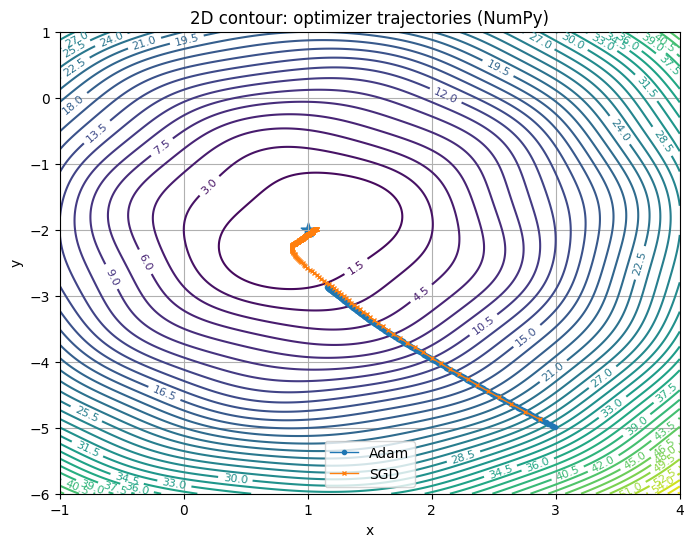

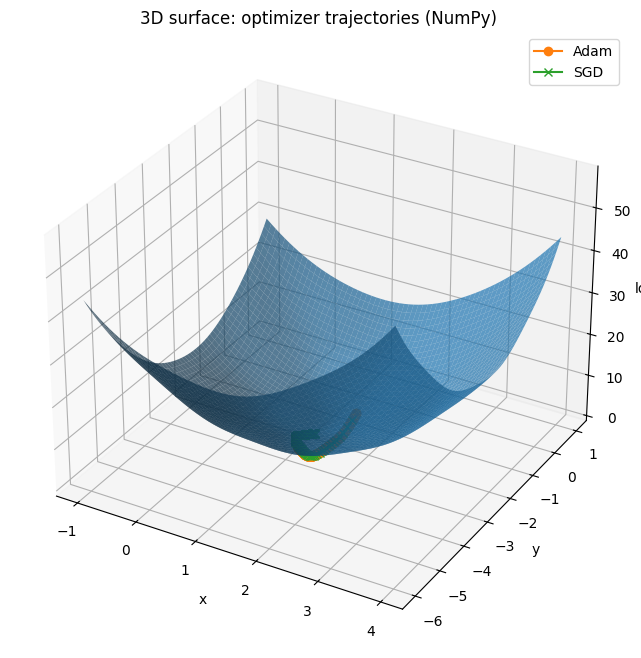

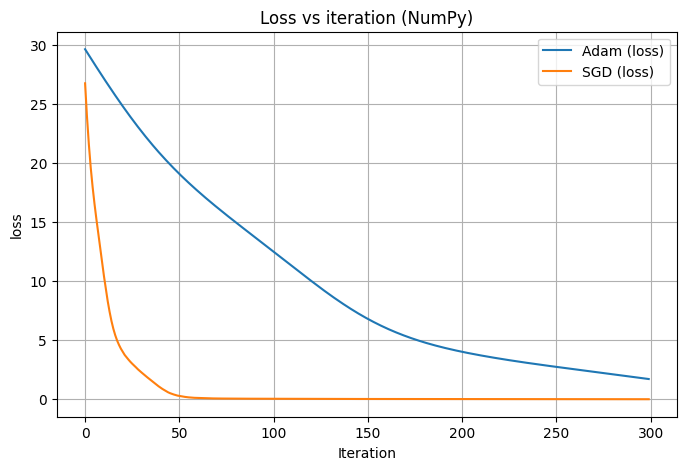

In [2]:
"""
adam_demo_numpy.py

NumPy-only implementation of Adam + visualizations (no PyTorch required).
Run:
    pip install matplotlib numpy
    python adam_demo_numpy.py
"""
import math, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# Loss & gradient (analytic)
def loss_np(theta):
    x,y = theta[0], theta[1]
    base = 3.0*(x-1.0)**2 + 2.0*(y+2.0)**2
    corr = 0.5*np.sin(3.0*x)*np.sin(3.0*y)
    return base + corr

def grad_np(theta):
    x,y = theta[0], theta[1]
    # d/dx of base + corr
    dx = 6.0*(x-1.0) + 0.5*(3.0*np.cos(3.0*x))*np.sin(3.0*y)
    dy = 4.0*(y+2.0) + 0.5*np.sin(3.0*x)*(3.0*np.cos(3.0*y))
    return np.array([dx, dy])

# NumPy Adam implementation
def adam_numpy(theta0, lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8, steps=300, noise_std=0.18):
    theta = theta0.copy().astype(float)
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    traj = []
    losses = []
    for t in range(1, steps+1):
        g = grad_np(theta)
        # add noise
        g = g + np.random.randn(*g.shape) * noise_std
        m = beta1*m + (1-beta1)*g
        v = beta2*v + (1-beta2)*(g*g)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta = theta - lr * m_hat / (np.sqrt(v_hat) + eps)
        traj.append(theta.copy())
        losses.append(loss_np(theta))
    return np.array(traj), np.array(losses)

# baseline SGD (NumPy)
def sgd_numpy(theta0, lr=1e-2, steps=300, noise_std=0.18):
    theta = theta0.copy().astype(float)
    traj = []
    losses = []
    for t in range(steps):
        g = grad_np(theta)
        g = g + np.random.randn(*g.shape) * noise_std
        theta = theta - lr * g
        traj.append(theta.copy())
        losses.append(loss_np(theta))
    return np.array(traj), np.array(losses)

# Run experiments
theta0 = np.array([3.0, -5.0])
adam_traj, adam_losses = adam_numpy(theta0, lr=0.01, steps=300, noise_std=0.18)
sgd_traj,  sgd_losses  = sgd_numpy(theta0, lr=0.01, steps=300, noise_std=0.18)

# Grid for plotting
grid_x = np.linspace(-1.0, 4.0, 250)
grid_y = np.linspace(-6.0, 1.0, 250)
X, Y = np.meshgrid(grid_x, grid_y)
Z = loss_np(np.stack([X, Y], axis=-1).reshape(-1,2).T).reshape(X.shape)  # compute slice

# 2D contour
plt.figure(figsize=(8,6))
CS = plt.contour(X, Y, Z, levels=40)
plt.clabel(CS, inline=1, fontsize=8)
plt.plot(adam_traj[:,0], adam_traj[:,1], marker='o', linewidth=1, markersize=3, label='Adam')
plt.plot(sgd_traj[:,0], sgd_traj[:,1], marker='x', linewidth=1, markersize=3, label='SGD')
plt.scatter([1.0], [-2.0], marker='*', s=120)
plt.title("2D contour: optimizer trajectories (NumPy)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True)
plt.show()

# 3D surface
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sub = (slice(None, None, 4), slice(None, None, 4))
ax.plot_surface(X[sub], Y[sub], Z[sub], rstride=1, cstride=1, alpha=0.7)
adam_z = loss_np(adam_traj.T)
sgd_z  = loss_np(sgd_traj.T)
ax.plot(adam_traj[:,0], adam_traj[:,1], adam_z, marker='o', label='Adam')
ax.plot(sgd_traj[:,0], sgd_traj[:,1], sgd_z, marker='x', label='SGD')
ax.set_title("3D surface: optimizer trajectories (NumPy)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("loss")
ax.legend()
plt.show()

# Loss vs iteration
plt.figure(figsize=(8,5))
plt.plot(adam_losses, label='Adam (loss)')
plt.plot(sgd_losses,  label='SGD (loss)')
plt.title("Loss vs iteration (NumPy)")
plt.xlabel("Iteration"); plt.ylabel("loss"); plt.legend(); plt.grid(True)
plt.show()
